In [1]:
# Imports
import os
import geopandas as gpd
import rasterio
from shapely.geometry import box

from rasterio.windows import Window, from_bounds
from eoreader.reader import Reader
from eoreader.bands import NDWI, SWIR_1

import hvplot.pandas
import hvplot.xarray

hvplot.extension('matplotlib')

In [2]:
# Open the product
folder = os.path.join("/home", "data", "DS3", "CI", "eoreader")
path = os.path.join(folder, "optical", "LC08_L1TP_200030_20201220_20210310_02_T1.tar")
reader = Reader()
prod = reader.open(path)
band = NDWI

In [3]:
# Here we have a window as a path to a vector
window_path = os.path.join(folder, "others", "20201220T104856_L8_200030_OLI_TIRS_window.geojson")
window_path

'/home/data/DS3/CI/eoreader/others/20201220T104856_L8_200030_OLI_TIRS_window.geojson'

/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/opt/conda/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


:Overlay
   .Polygons.I  :Polygons   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
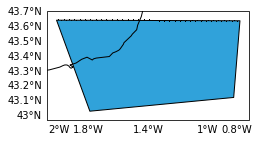

In [4]:
# Here we have the vector directly opened as a geopanas.GeoDataFrame
window_gdf = gpd.read_file(window_path)
window_gdf.to_crs("EPSG:4326").hvplot(coastline="10m")

In [5]:
# Here we have an array of the bounds (tuple or list also works)
window_bounds = window_gdf.bounds.values[0]
window_bounds

array([ 579046.01517122, 4765387.52325064,  678660.50985682,
       4834693.77806381])

In [6]:
# Here we construct a Window containing directly the pixels 
# It is not necessary to have a window with integers values, they will be rounded when needed.
# However, it is better to control exactly the pixels you want so it is advised to round the values yourself
with rasterio.open(str(prod.get_band_paths([SWIR_1])[SWIR_1])) as ds:
    window_pix = from_bounds(*window_bounds, ds.transform)
window_pix

Window(col_off=1932.033839040505, row_off=2154.040731206187, width=3320.4831561867395, height=2310.2084937724576)

In [7]:
# Create function to time it easily
def load(prod, window):
    """
    Function that loads the wanted band over a proposed window and cleans the temporary directory.    
    """
    ds = prod.load(
        band,
        window=window
    )
    prod.clean_tmp()
    return ds[band]

In [8]:
%time band_arr = load(prod, None)

CPU times: user 20.5 s, sys: 2.03 s, total: 22.5 s
Wall time: 14.9 s


In [9]:
%time band_arr_win_path = load(prod, window_path)

CPU times: user 2.79 s, sys: 305 ms, total: 3.09 s
Wall time: 1.61 s


In [10]:
%time band_arr_win_gdf = load(prod, window_gdf)

CPU times: user 2.91 s, sys: 333 ms, total: 3.24 s
Wall time: 1.64 s


In [11]:
%time band_arr_win_bounds = load(prod, window_bounds)

CPU times: user 2.89 s, sys: 295 ms, total: 3.19 s
Wall time: 1.62 s


In [12]:
%time band_arr_win_pix = load(prod, window_pix)

CPU times: user 2.81 s, sys: 284 ms, total: 3.09 s
Wall time: 1.52 s


In [13]:
assert band_arr_win_path.shape == band_arr_win_gdf.shape == band_arr_win_bounds.shape == band_arr_win_pix.shape

In [14]:
band_arr_win_path.shape

(1, 2311, 3321)

In [15]:
band_arr.shape

(1, 7811, 7681)

:Overlay
   .QuadMesh.I   :QuadMesh   [x,y]   (NDWI)
   .Coastline.I  :Feature   [Longitude,Latitude]
   .QuadMesh.II  :QuadMesh   [x,y]   (NDWI)
   .Coastline.II :Feature   [Longitude,Latitude]
   .Polygons.I   :Polygons   [x,y]
   .Polygons.II  :Polygons   [x,y]
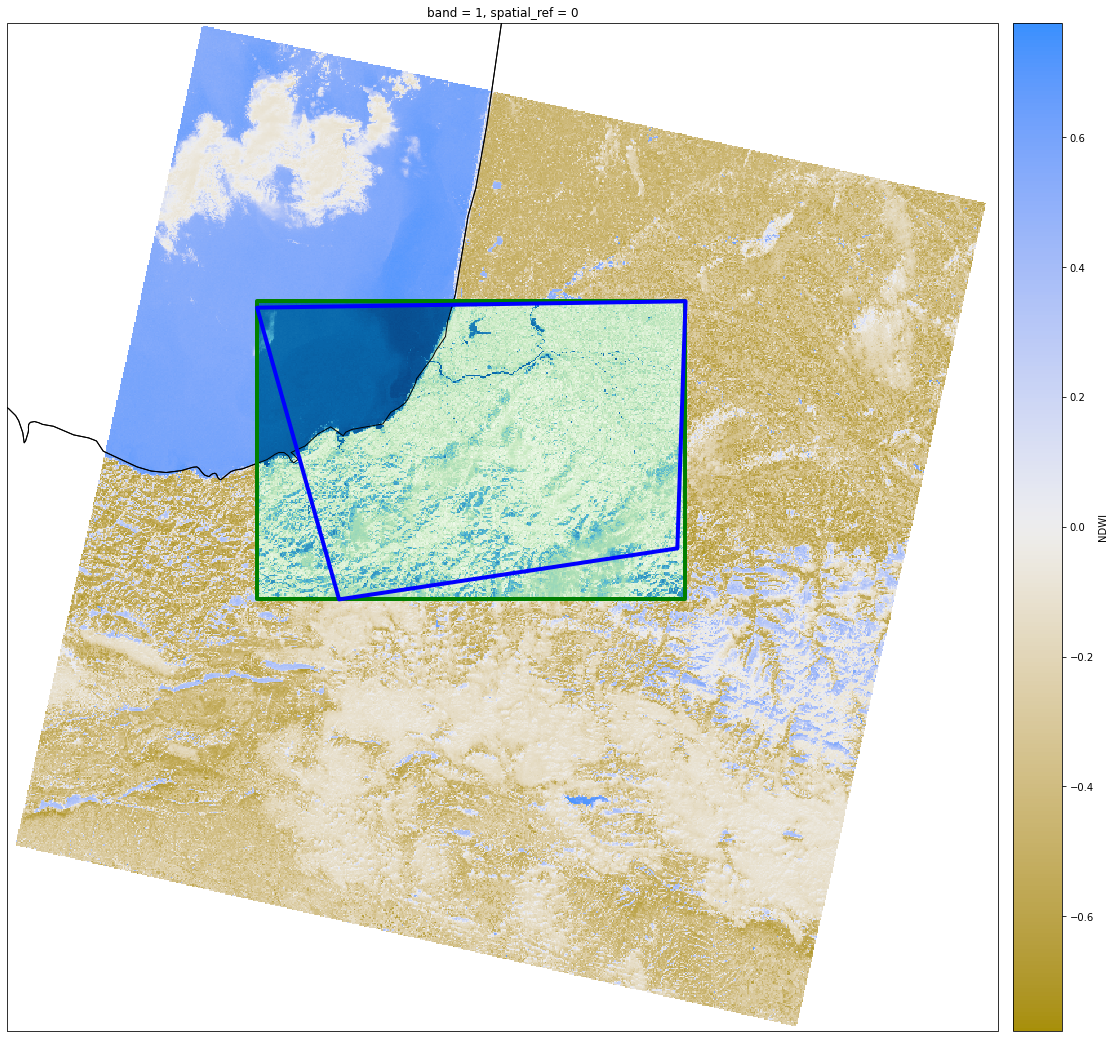

In [16]:
%%opts QuadMesh [fig_size=500]

# Compute bounds
bounds = band_arr.rio.bounds()
window_bounds_gpd = gpd.GeoDataFrame(
    geometry=[box(*window_bounds)],
    crs=window_gdf.crs
)

# Plot
band_arr[0, ::10, ::10].hvplot.quadmesh(
    "x", "y", 
    coastline="10m",
    cmap="bwy_r"
) * band_arr_win_path[0, ::10, ::10].hvplot.quadmesh(
    "x", "y", 
    coastline="10m",
    cmap="GnBu"
) * window_bounds_gpd.hvplot(
    facecolor=(0, 0, 0, 0), 
    edgecolor="g", linewidth=4
) * window_gdf.hvplot(
    facecolor=(0, 0, 0, 0), 
    edgecolor="b", linewidth=4, 
    xlim=(bounds[0], bounds[2]), 
    ylim=(bounds[1], bounds[3])
)